In [1]:
## Add path to sys
import sys
sys.path.append('../../')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing import data_processing
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
train_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/train/'
test_dataset = 'D:/Projects/tumai_braintumor_classification/dataset/test/'
IMG_SIZE = (224,224)

X_train, y_train, labels = data_processing.load_data_tonumpy(train_dataset, IMG_SIZE)
X_test, y_test, _ = data_processing.load_data_tonumpy(test_dataset, IMG_SIZE)


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


202 images loaded from D:/Projects/tumai_braintumor_classification/dataset/train/ directory.


100%|██████████| 2/2 [00:00<00:00,  8.97it/s]

51 images loaded from D:/Projects/tumai_braintumor_classification/dataset/test/ directory.


## Image cropping example
https://www.kaggle.com/code/fadhlalhafizh/brain-tumor-vgg16-resnet50-inceptionv3

In [3]:
import cv2
import imutils

In [4]:
img = X_train[3]
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

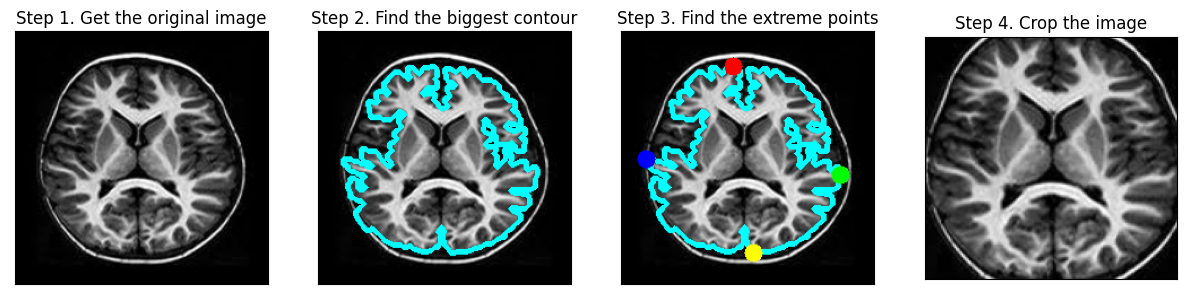

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()


In [6]:
# apply this for each set
X_train_crop = data_processing.crop_imgs(set_name=X_train)
X_test_crop = data_processing.crop_imgs(set_name=X_test)

### Trying TL Models

In [7]:
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.applications.vgg16 import preprocess_input
from keras.models import Model, Sequential
from matplotlib import pyplot 
from numpy import expand_dims

In [8]:
def preprocess_for_vgg(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        # set_new.append(preprocess_input(img))
        set_new.append(img/255)
    return np.array(set_new)

In [9]:
X_train_prep = preprocess_for_vgg(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_for_vgg(set_name=X_test_crop, img_size=IMG_SIZE)

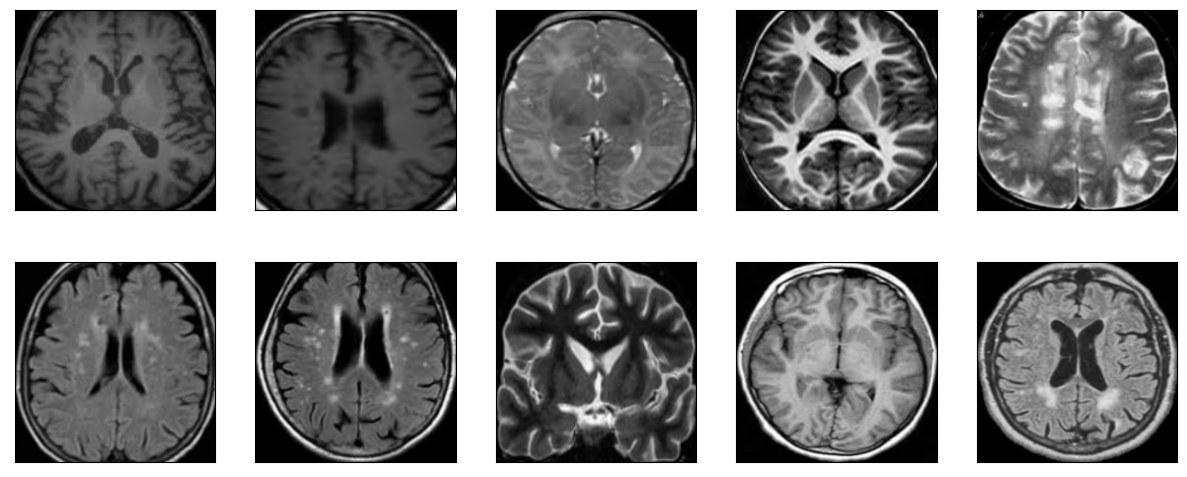

In [10]:
## Plot 10 images from X_train_crop
plt.figure(figsize=(15,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_prep[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [11]:
## Make a VGG16 model and freeze the layers and add a head 
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16.trainable = False
model = Sequential()
model.add(vgg16)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


## Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

## Early stopping
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27,560,769
Trainable params: 12,846,081
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
model.fit(
    X_train_prep,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_prep, y_test),
    callbacks=[early_stopping]
)

Epoch 1/10
7/7 [==============================] - 38s 5s/step - loss: 3.9514 - accuracy: 0.5000 - val_loss: 2.3367 - val_accuracy: 0.6078
Epoch 2/10
7/7 [==============================] - 34s 5s/step - loss: 1.8819 - accuracy: 0.6683 - val_loss: 1.6646 - val_accuracy: 0.4118
Epoch 3/10
7/7 [==============================] - 35s 5s/step - loss: 0.8159 - accuracy: 0.6535 - val_loss: 0.7055 - val_accuracy: 0.6667
Epoch 4/10
7/7 [==============================] - 35s 5s/step - loss: 0.3761 - accuracy: 0.8366 - val_loss: 0.6076 - val_accuracy: 0.6863
Epoch 5/10
7/7 [==============================] - 35s 5s/step - loss: 0.2746 - accuracy: 0.8861 - val_loss: 0.3836 - val_accuracy: 0.8039
Epoch 6/10
7/7 [==============================] - 36s 5s/step - loss: 0.1696 - accuracy: 0.9406 - val_loss: 0.3508 - val_accuracy: 0.8431
Epoch 7/10
7/7 [==============================] - 34s 5s/step - loss: 0.1228 - accuracy: 0.9703 - val_loss: 0.2854 - val_accuracy: 0.8824
Epoch 8/10
7/7 [==================

In [13]:
model.evaluate(X_test_prep, y_test)

2/2 [==============================] - 6s 2s/step - loss: 0.2366 - accuracy: 0.9020


[0.2366309016942978, 0.9019607901573181]

## Checking the model

In [14]:
from sklearn.metrics import f1_score, confusion_matrix

y_pred = model.predict(X_test_prep)
y_pred = np.where(y_pred > 0.5, 1, 0)

f1_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

2/2 [==============================] - 6s 2s/step


array([[19,  1],
       [ 4, 27]], dtype=int64)

In [15]:
## Get all X_test and y_test with wrong prediction

X_test_wrong = X_test_prep[y_test != y_pred.reshape(-1)]
y_test_wrong = y_test[y_test != y_pred.reshape(-1)]

X_test_right = X_test_prep[y_test == y_pred.reshape(-1)]
y_test_right = y_test[y_test == y_pred.reshape(-1)]

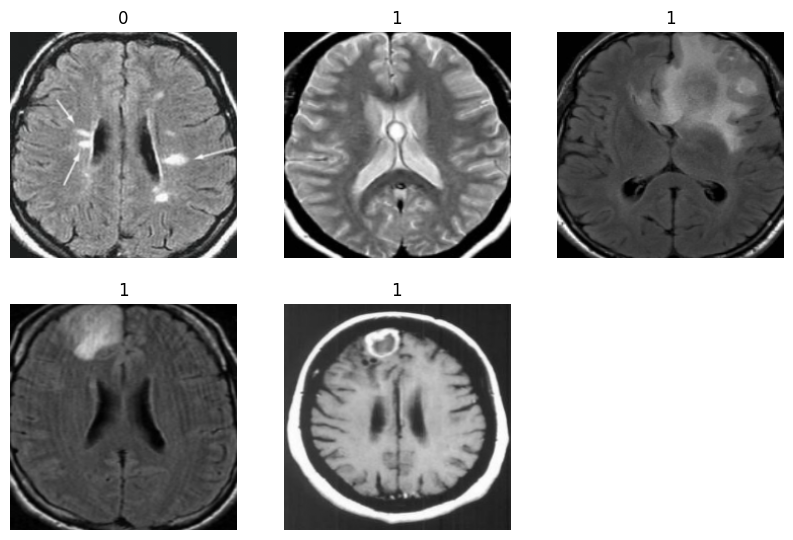

In [17]:
## Plot all wrong prediction

plt.figure(figsize=(10, 10))
for i in range(len(X_test_wrong)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_wrong[i], cmap='gray')
    plt.title(str(y_test_wrong[i]))
    plt.axis("off")

plt.show()

## SHAP explanations

In [20]:
import shap
explainer = shap.DeepExplainer(model, data=X_test_prep)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


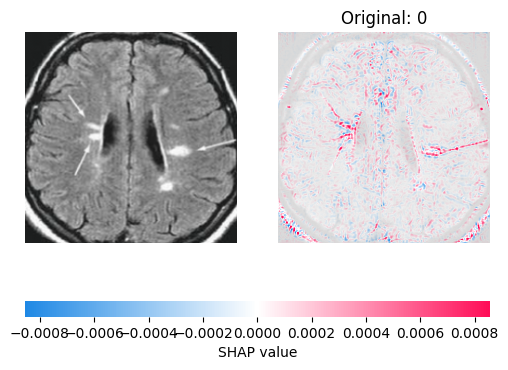

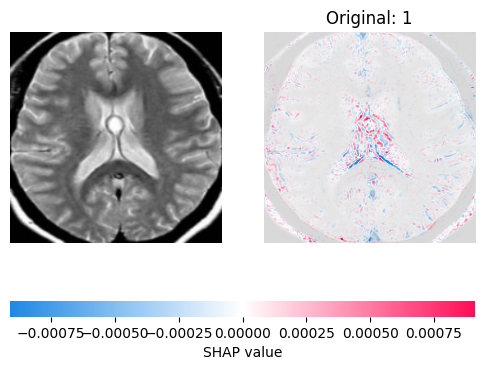

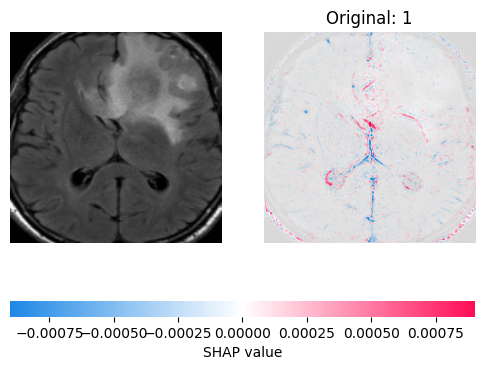

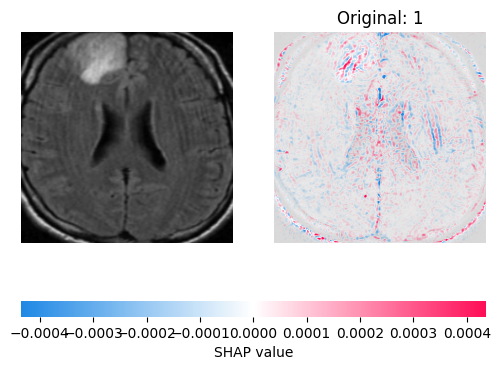

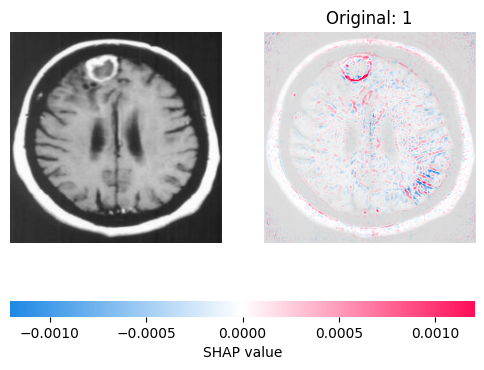

In [21]:
## Using SHAP to explain the model
import shap
# Create an explainer object
for i in range(len(X_test_wrong)):
    # Get a sample the wrong prediction
    sample = X_test_wrong[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_wrong[i]))
    plt.show()

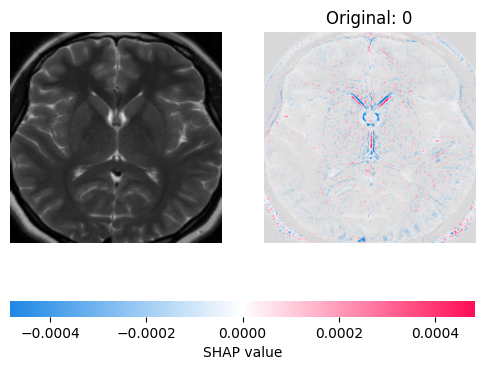

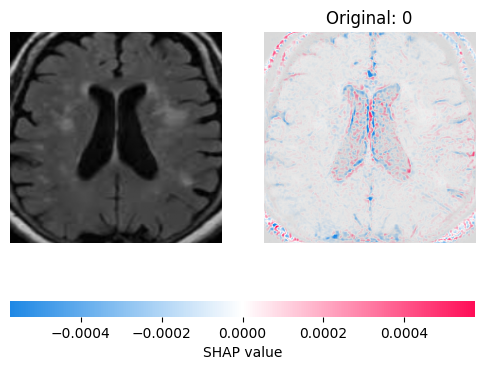

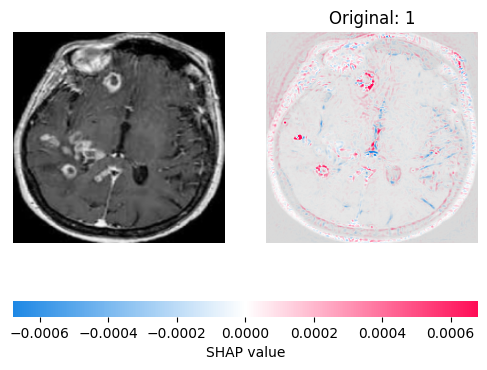

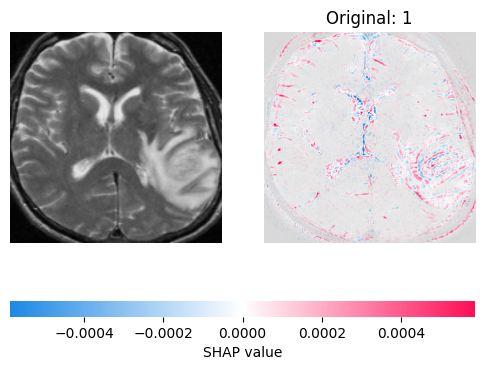

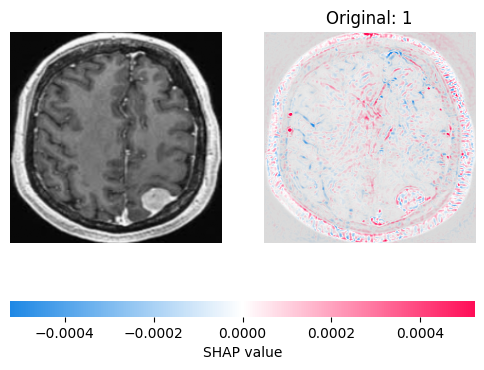

In [22]:
import shap
# Create an explainer object
for i in [0,5,-4,-5,-7]:
    # Get a sample the wrong prediction
    sample = X_test_right[i].reshape(1, 224, 224, 3)
    # Get the shap values
    shap_values = explainer.shap_values(sample)
    # Plot the shap values
    ## Add the original and probability of the wrong prediction
    shap.image_plot(shap_values, sample, show=False)
    plt.title('Original: ' + str(y_test_right[i]))
    plt.show()


## LIME Explanations

In [23]:
def prediction_function(images):
     return model.predict(images, verbose=False)

100%|██████████| 50/50 [00:04<00:00, 10.57it/s]


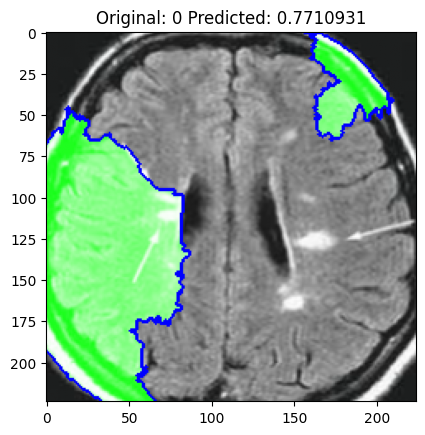

100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


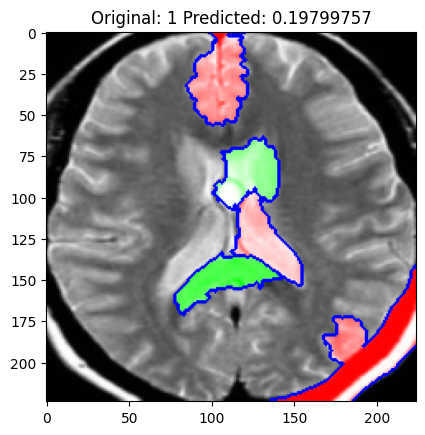

100%|██████████| 50/50 [00:04<00:00, 11.67it/s]


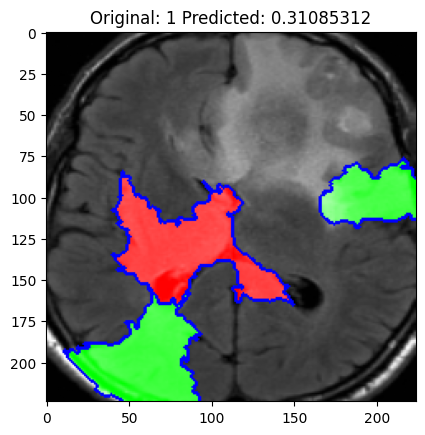

100%|██████████| 50/50 [00:04<00:00, 11.84it/s]


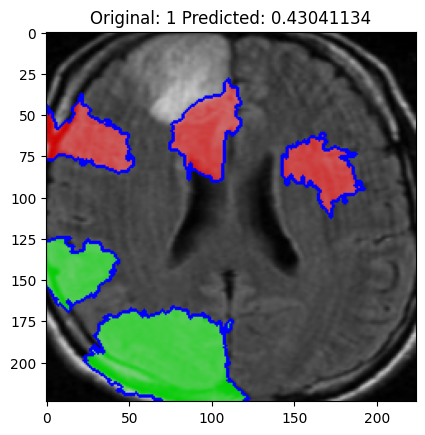

100%|██████████| 50/50 [00:04<00:00, 10.02it/s]


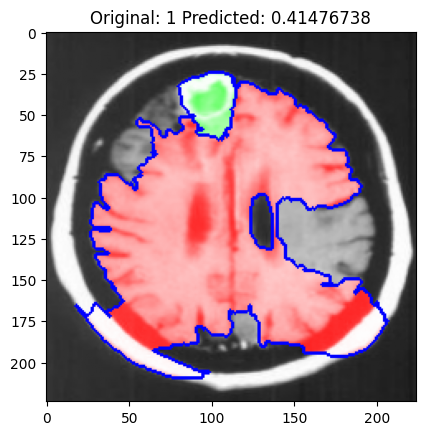

In [25]:
from skimage.segmentation import mark_boundaries
from lime import lime_image

for i in range(len(X_test_wrong)):
     explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
     explanation = explainer.explain_instance(
          X_test_wrong[i],
          prediction_function,
          num_samples=50         
     )

     plt.title('Original: ' + str(y_test_wrong[i]) + ' Predicted: ' + str(model.predict(X_test_wrong[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
     plt.imshow(X_test_wrong[i])
     image, mask = explanation.get_image_and_mask(
          model.predict(
               X_test_wrong[0].reshape(1, 224, 224, 3), verbose=False
          ).argmax(axis=1)[0],
          positive_only=False,
          negative_only=False,
          hide_rest=False
     )
     plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
     plt.show()

100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


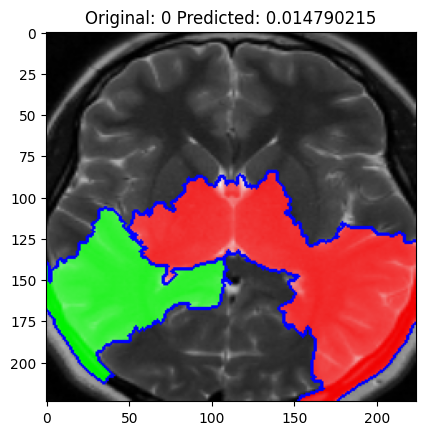

100%|██████████| 50/50 [00:04<00:00, 11.85it/s]


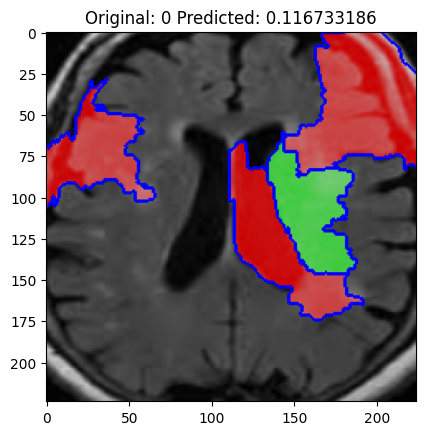

100%|██████████| 50/50 [00:04<00:00, 12.12it/s]


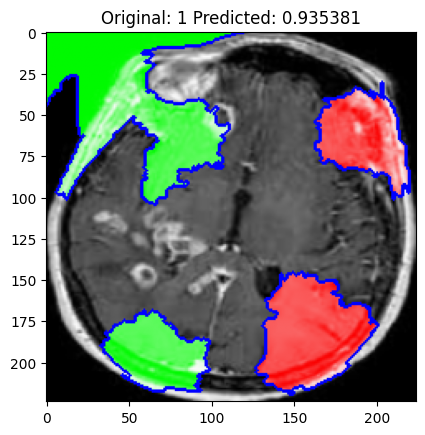

100%|██████████| 50/50 [00:04<00:00, 11.61it/s]


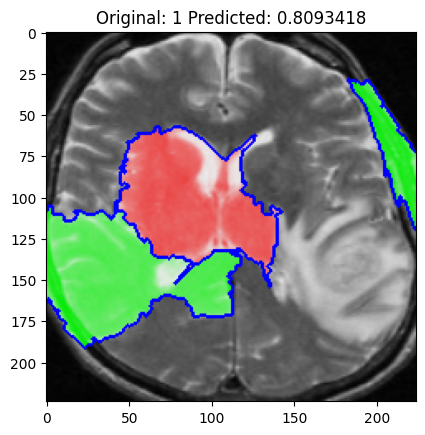

100%|██████████| 50/50 [00:04<00:00, 11.85it/s]


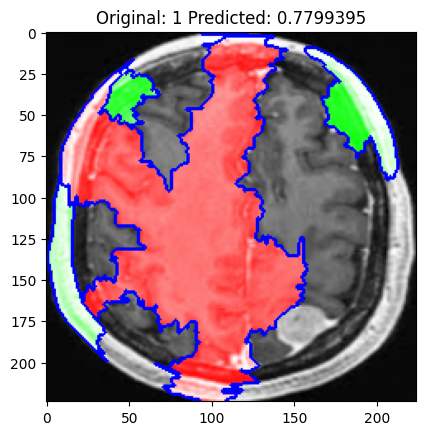

In [26]:
## Write the above code for X_test_right
for i in [0,5,-4,-5,-7]:
    explainer = lime_image.LimeImageExplainer(random_state=42, verbose=False)
    explanation = explainer.explain_instance(
        X_test_right[i],
        prediction_function,
        num_samples=50         
    )

    plt.title('Original: ' + str(y_test_right[i]) + ' Predicted: ' + str(model.predict(X_test_right[i].reshape(1, 224, 224, 3), verbose=False)[0][0]))
    plt.imshow(X_test_right[i])
    image, mask = explanation.get_image_and_mask(
        model.predict(
            X_test_right[0].reshape(1, 224, 224, 3), verbose=False
        ).argmax(axis=1)[0],
        positive_only=False,
        negative_only=False,
        hide_rest=False
    )
    plt.imshow(mark_boundaries(image, mask, color=(0, 0, 1), mode='thick'))
    plt.show()
